In [2]:
""" model: gpt2
- (Vaswani et al. 2017 https://arxiv.org/abs/1706.03762)
- (Radford et al. 2019 https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
- (Brown et al. 2020 https://arxiv.org/abs/2005.14165)

pre-gpt       ->    gpt2                                 URL
-----------------------------------------------------------------------------------------
- ReLU        ->    GeLU: (Hendrycks, Gimpel 2016)       https://arxiv.org/abs/1606.08415
- BatchNorm   ->    LayerNorm: (Ba et al. 2016)          https://arxiv.org/abs/1607.06450
- N/A         ->    Residuals: (He et al. 2015)          https://arxiv.org/abs/1512.03385)


Dimension key:

# windows
B: batch size
T: sequence length

# input/output
V: vocabulary size
D: model dimension (n_embd)

# attention
N: number of transformer blocks (n_layer)
H: number of attention heads in a layer (n_head)
K: size of each attention key or value (n_k)
"""
from dataclasses import dataclass
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1337)
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

@dataclass
class GPTConfig:
    # windows: B, T
    batch_size: int = -1   # B
    block_size: int = 1024  # T
    # input/output:  V, D
    vocab_size: int = 50257  # V (256 bytes + 50,000 BPE merges + 1 <|endoftext|> token)
    n_embd: int = 768      # D
    # attn: NH
    n_layer: int = 12      # N
    n_head: int = 12       # H

class MHA(nn.Module):
    def __init__(self, config):
        super().__init__()
        T, D, H = config.block_size, config.n_embd, config.n_head
        assert D % H == 0

        self.H = H

        self.c_attn = nn.Linear(D, 3 * D)
        self.c_proj = nn.Linear(D, D)
        self.c_proj.GPT2_SCALE_INIT = 1
        self.register_buffer('bias', torch.tril(torch.ones(T, T)).view(1, 1, T, T)) # tril -> bias for HF

    def forward(self, X_BTD):
        B,T,D = X_BTD.shape
        H = self.H
        # 1. project to learned QKV subspaces Q=WqX, K=WkX, V=WvX
        Wq_DK, Wk_DK, Wv_DK = self.c_attn(X_BTD).split(D, dim=2)
        Q_BHTK, K_BHTK, V_BHTK = Wq_DK.view(B, T, H, D // H).transpose(1, 2), Wk_DK.view(B, T, H, D // H).transpose(1, 2), Wv_DK.view(B, T, H, D // H).transpose(1, 2)

        # 2. evaluate scores A(QKV) = softmax(QK^T/sqrt(d_k))V
        A_BHTT = Q_BHTK @ K_BHTK.transpose(-2, -1) * (1.0 / math.sqrt(K_BHTK.size(-1)))
        A_BHTT = A_BHTT.masked_fill(self.bias[:, :, :T, :T]==0, float('-inf'))
        A_BHTT = F.softmax(A_BHTT, dim=-1) # todo, when dim=-1?

        # 3. contextualize the embeddings
        S_BHTD = A_BHTT @ V_BHTK
        S_BTD = S_BHTD.transpose(1, 2).contiguous().view(B, T, D) # performs cat
        S_BTD = self.c_proj(S_BTD)

        return S_BTD

class FFN(nn.Module):
    def __init__(self, config):
        super().__init__()
        D = config.n_embd
        self.c_fc = nn.Linear(D, 4*D) # projecting up to extract features from context embeddings
        self.gelu = nn.GELU(approximate='tanh') # (Hendrycks et al. https://arxiv.org/abs/1606.08415)
        self.c_proj = nn.Linear(4*D, D) # projecting back down to residual pathway
        self.c_proj.GPT2_SCALE_INIT = 1

    def forward(self, X_BTD):
        X_BT4D = self.c_fc(X_BTD)
        X_BT4D = self.gelu(X_BT4D)
        X_BTD = self.c_proj(X_BT4D)
        return X_BTD





# class LayerNorm(nn.Module): # manual inefficient LayerNorm implementation
#     def __init__(self):
#         super().__init__()

#     def forward():
#         # ...

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        D, H = config.n_embd, config.n_head
        self.ln_1 = nn.LayerNorm(D)
        self.attn = MHA(config)
        self.mlp = FFN(config) # .mlp for HF
        self.ln_2 = nn.LayerNorm(D)

    def forward(self, X_BTD):
        # residuals:
        # - (He et al. 2015 https://arxiv.org/abs/1512.03385)
        # - (Elhage et al. 2021 https://transformer-circuits.pub/2021/framework/index.html)
        X_BTD = X_BTD + self.attn(self.ln_1(X_BTD))
        X_BTD = X_BTD + self.mlp(self.ln_2(X_BTD))
        return X_BTD





class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        B, T = config.batch_size, config.block_size
        V, D = config.vocab_size, config.n_embd
        N, H = config.n_layer, config.n_head

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(V, D), # Wt
            wpe = nn.Embedding(T, D), # Wp
            h = nn.ModuleList([Block(config) for _ in range(N)]),
            ln_f = nn.LayerNorm(D),
        ))
        self.lm_head = nn.Linear(D, V, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # weight sharing (40m/120m ~30% save)
        self.apply(self._init_weights) # weight init (roughly Xavier)

    def _init_weights(self, module):
        std=0.02 # default std for nn.Linear() and nn.Embedding(). nn.LayerNorm defaults are OK
        if isinstance(module, nn.Linear):
            if hasattr(module, 'GPT2_SCALE_INIT'):
                std = (2 * self.config.n_layer ** -0.5)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias) # instead of default of unit gaussian

        if isinstance(module, nn.Linear) or isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std) # ~ 1/sqrt(D={768, 1024, 1280, 1600}) (Xavier init)

    def forward(self, X_BT, Y_BT=None): # Some(Y_BT) => training, None => inference
        B, T = X_BT.shape
        # 1. embedding: BTD
        Xtok_BTD = self.transformer.wte(X_BT)
        Xpos_TD = self.transformer.wpe(torch.arange(0, T, dtype=torch.long, device=X_BT.device))
        X_BTD = Xtok_BTD + Xpos_TD
        # 2. N transformer blocks: Nx(BTD -> BTK -> BTD)
        for h in self.transformer.h:
            X_BTD = h(X_BTD)
        # 3. logits: BTD -> BTV
        X_BTD = self.transformer.ln_f(X_BTD)
        logits_BTV = self.lm_head(X_BTD)
        loss = None

        if Y_BT is not None:
            V = self.config.vocab_size
            loss = F.cross_entropy(logits_BTV.view(B*T, V), Y_BT.view(B*T)) # reshape for .cross_entropy()
        return logits_BTV, loss
 
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints



        # 1. model init
        model_hf, model = GPT2LMHeadModel.from_pretrained(model_type), GPT(GPTConfig(**config_args))
        sdhf, sd = model_hf.state_dict(), model.state_dict()
        sdhf_keys, sd_keys = sdhf.keys(), sd.keys() # .collect::<Vec<_>>() semantics
        # filter
        sdhf_keys = [k for k in sdhf_keys if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sdhf_keys = [k for k in sdhf_keys if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # 2. copy
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        assert len(sdhf_keys) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sdhf_keys:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sdhf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sdhf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sdhf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sdhf[k])

        return model

# model = GPT.from_pretrained('gpt2')
model = GPT(GPTConfig())
model.to(device)
print(f'model loaded to {device}')

using device: cuda
model loaded to cuda


loaded 338025 tokens
1 epoch = 2640 batches
step: 0, loss: 10.987553596496582
step: 1, loss: 9.876352310180664
step: 2, loss: 9.145299911499023
step: 3, loss: 9.197213172912598
step: 4, loss: 8.809774398803711
step: 5, loss: 8.441530227661133
step: 6, loss: 8.952258110046387
step: 7, loss: 8.901835441589355
step: 8, loss: 8.164588928222656
step: 9, loss: 8.052652359008789
step: 10, loss: 8.408546447753906
step: 11, loss: 7.499998092651367
step: 12, loss: 7.825485706329346
step: 13, loss: 7.467976093292236
step: 14, loss: 7.565077304840088
step: 15, loss: 7.431253910064697
step: 16, loss: 7.508831024169922
step: 17, loss: 8.28786563873291
step: 18, loss: 7.194320201873779
step: 19, loss: 7.874356746673584
step: 20, loss: 7.476627349853516
step: 21, loss: 7.820918083190918
step: 22, loss: 6.452661037445068
step: 23, loss: 6.874929428100586
step: 24, loss: 6.826265811920166
step: 25, loss: 6.69091272354126
step: 26, loss: 6.798330307006836
step: 27, loss: 7.612519264221191
step: 28, loss:

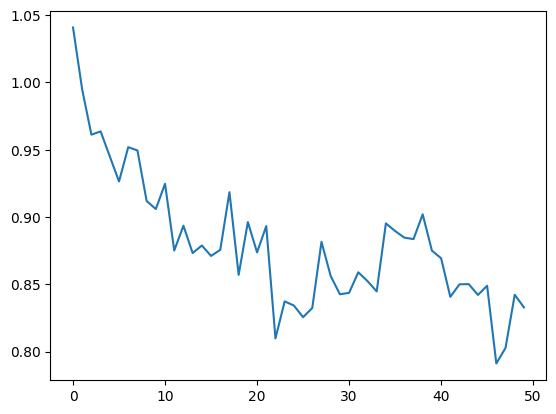

In [3]:
""" training loop
(Jordan et al. 2024) URL: https://github.com/KellerJordan/modded-nanogpt
124M 10x speedup: 45m -> 4m
========================================================================
- network architecture: rotary embeddings, QK-norm, ReLU^2
- muon optimizer
- untie head & embedding, FP8 matmul for head, softcap logits (gemma 2)
- projection and classification layers init to zero (muP)
- skip connections from embedding to every block (and between) via U-net
- flexattention with long-short sliding window attention (gemma 2), window size warmup

        124M history:
        01. 45.0m baseline
        02. 31.4m tuned lr, rotary embeddings
        03. 24.9m muon optimizer
        04. 22.3m muon improvements
        05. 15.2m pad embeddings, ReLU^2, zero init, QK-norm
        06. 13.1m muon overhead
        07. 12.0m pytorch 2.5.0
        08. 10.8m united embedding and head
        09. 08.2m value and embed skip connections, momentum warmup, logit softcap
        10. 07.8m bfloat16 act
        11. 07.2m u-net pattern skip connections, double lr
        12. 05.0m 1024-ctx dense causal attn -> 64K-ctx flex attention
        13. 04.6m attention window warmup
        14. 04.4m value embededdings
"""
import torch
import tiktoken

# 1. dataloader
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
        with open('./data/shakespeare.txt', 'r') as f:
            text = f.read()
        encoder = tiktoken.get_encoding('gpt2')
        self.tokens = torch.tensor(encoder.encode(text))
        self.i = 0

        print(f"loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B*T)} batches")

    def next_batch(self):
        B, T = self.B, self.T
        tokens = self.tokens[self.i:self.i+(B*T+1)]
        X_BT, Y_BT = tokens[:-1].view(B,T), tokens[1:].view(B,T)
        self.i += B*T
        if self.i + (B*T+1) > len(self.tokens):
            self.i = 0

        return X_BT, Y_BT
# print(X_BT)
# print(Y_BT)
# for b in range(B):
#     print('batch', b)
#     for t in range(T):
#         context = X_BT[b, :t+1]
#         target = Y_BT[b, t]
#         print('x:', context, '->', 'y:', target)

# print("==========================================")

# 2. training loop
import matplotlib.pyplot as plt
%matplotlib inline

train_loader = DataLoaderLite(B=4, T=32)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
steps, losses = [], []
for step in range(50):
    X_BT, Y_BT = train_loader.next_batch()
    X_BT, Y_BT = X_BT.to(device), Y_BT.to(device)

    # 1. forward
    optimizer.zero_grad()
    logits_BTV, loss = model(X_BT, Y_BT)
    # 2. backward
    loss.backward()
    # 3. step
    optimizer.step()

    steps.append(step)
    losses.append(loss.log10().item())
    print(f"step: {step}, loss: {loss.item()}")

plt.plot(steps, losses)
print(loss.item())

In [4]:
B, T_MAX = 5, 30
model.eval()

import tiktoken
encoder = tiktoken.get_encoding('gpt2')
tokens = encoder.encode("Hello, I'm a language model,")
tokens_T = torch.tensor(tokens, dtype=torch.long) # # (T,)
tokens_BT = tokens_T.unsqueeze(0).repeat(5, 1) # (B,T)
X_BT = tokens_BT.to(device)

if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)
while X_BT.size(1) < T_MAX:
    with torch.no_grad():
        logits_BTV, _ = model(X_BT)
        logits_BV = logits_BTV[:, -1, :]
        probs_ = F.softmax(logits_BV, dim=-1)
        topk_probs_, topk_indices_ = torch.topk(probs_, 50, dim=-1)

        X_B1 = torch.gather(topk_indices_, -1, torch.multinomial(topk_probs_, 1))
        X_BT = torch.cat((X_BT, X_B1), dim=1)

for b in range(B):
    tokens = X_BT[b, :T_MAX].tolist()
    decoded = encoder.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model,

, him:
IA how!



's I your
 and yet have, he
> Hello, I'm a language model,N

:



' his.


, him but

 the the upon
> Hello, I'm a language model,
. and; have not.

:.'
VOL. his

 you
:

> Hello, I'm a language model,.

,
:



,,
,,
, their

, he
> Hello, I'm a language model,

:





:


: in.
,;

 good
